<a href="https://colab.research.google.com/github/florinOK/amr/blob/colab/vae_sentences/vae-att-sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[Generating Sentences from a Continuous Space](https://arxiv.org/pdf/1511.06349.pdf)  
[Reasoning about Entailment with Neural Attention](https://arxiv.org/pdf/1509.06664.pdf)  
[Deconvolutional Latent-Variable Model for Text Sequence Matching](https://arxiv.org/pdf/1709.07109.pdf)  

---
https://github.com/baaesh/DeConv-VAE-pytorch  
https://github.com/Toni-Antonova/VAE-Text-Generation  
https://github.com/alexeyev/Keras-Generating-Sentences-from-a-Continuous-Space  


In [1]:
! nvidia-smi

Thu Aug 27 08:16:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [2]:
# SNLI
! curl https://nlp.stanford.edu/projects/snli/snli_1.0.zip -o snli_1.0.zip
! unzip snli_1.0.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  8672k      0  0:00:10  0:00:10 --:--:-- 7096k
Archive:  snli_1.0.zip
   creating: data/snli_1.0/
  inflating: data/snli_1.0/.DS_Store  
   creating: data/__MACOSX/
   creating: data/__MACOSX/snli_1.0/
  inflating: data/__MACOSX/snli_1.0/._.DS_Store  
 extracting: data/snli_1.0/Icon      
  inflating: data/__MACOSX/snli_1.0/._Icon  
  inflating: data/snli_1.0/README.txt  
  inflating: data/__MACOSX/snli_1.0/._README.txt  
  inflating: data/snli_1.0/snli_1.0_dev.jsonl  
  inflating: data/snli_1.0/snli_1.0_dev.txt  
  inflating: data/snli_1.0/snli_1.0_test.jsonl  
  inflating: data/snli_1.0/snli_1.0_test.txt  
  inflating: data/snli_1.0/snli_1.0_train.jsonl  
  inflating: data/snli_1.0/snli_1.0_train.txt  
  inflating: data/__MACOSX/._snli_1.0  


In [ ]:
# QQP

In [ ]:
# PTB

In [ ]:
# Glove
! wget http://nlp.stanford.edu/data/glove.840B.300d.zip
! unzip glove.840B.300d.zip -d data/glove

--2020-08-26 08:23:33--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-08-26 08:23:34--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-08-26 08:23:34--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

# Code

In [ ]:
import re
import json
import time
import logging
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import tensorflow_probability as tfp

import matplotlib.pyplot as plt

from IPython import display

In [ ]:
p = sns.color_palette()

pd.set_option('display.max_rows', 64)
pd.set_option('display.max_columns', 64)
pd.set_option('display.max_colwidth', 1024)

logging.basicConfig(level='INFO', format="%(asctime)s [%(levelname)-5.5s] [%(funcName)-32s]  %(message)s")

In [ ]:
# config

EMBS = 'data/glove/glove.840B.300d.txt'
TRAIN_DATASET = 'data/snli_1.0/snli_1.0_test.jsonl'


In [306]:
def load_dataset(path):
    dataset = []
    with open(path) as fp:
        for line in fp.readlines():
            dataset.append(json.loads(line))
    return pd.DataFrame(dataset)


train_dataset = load_dataset(TRAIN_DATASET)

In [307]:
train_dataset.shape  # (550152, 10)

(10000, 10)

In [308]:
train_dataset.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,"[neutral, contradiction, contradiction, neutral, neutral]",2677109430.jpg#1,neutral,2677109430.jpg#1r1n,This church choir sings to the masses as they sing joyous songs from the book at a church.,( ( This ( church choir ) ) ( ( ( sings ( to ( the masses ) ) ) ( as ( they ( ( sing ( joyous songs ) ) ( from ( ( the book ) ( at ( a church ) ) ) ) ) ) ) ) . ) ),(ROOT (S (NP (DT This) (NN church) (NN choir)) (VP (VBZ sings) (PP (TO to) (NP (DT the) (NNS masses))) (SBAR (IN as) (S (NP (PRP they)) (VP (VBP sing) (NP (JJ joyous) (NNS songs)) (PP (IN from) (NP (NP (DT the) (NN book)) (PP (IN at) (NP (DT a) (NN church))))))))) (. .))),The church has cracks in the ceiling.,( ( The church ) ( ( has ( cracks ( in ( the ceiling ) ) ) ) . ) ),(ROOT (S (NP (DT The) (NN church)) (VP (VBZ has) (NP (NP (NNS cracks)) (PP (IN in) (NP (DT the) (NN ceiling))))) (. .)))
1,"[entailment, entailment, entailment, neutral, entailment]",2677109430.jpg#1,entailment,2677109430.jpg#1r1e,This church choir sings to the masses as they sing joyous songs from the book at a church.,( ( This ( church choir ) ) ( ( ( sings ( to ( the masses ) ) ) ( as ( they ( ( sing ( joyous songs ) ) ( from ( ( the book ) ( at ( a church ) ) ) ) ) ) ) ) . ) ),(ROOT (S (NP (DT This) (NN church) (NN choir)) (VP (VBZ sings) (PP (TO to) (NP (DT the) (NNS masses))) (SBAR (IN as) (S (NP (PRP they)) (VP (VBP sing) (NP (JJ joyous) (NNS songs)) (PP (IN from) (NP (NP (DT the) (NN book)) (PP (IN at) (NP (DT a) (NN church))))))))) (. .))),The church is filled with song.,( ( The church ) ( ( is ( filled ( with song ) ) ) . ) ),(ROOT (S (NP (DT The) (NN church)) (VP (VBZ is) (VP (VBN filled) (PP (IN with) (NP (NN song))))) (. .)))
2,"[contradiction, contradiction, contradiction, contradiction, contradiction]",2677109430.jpg#1,contradiction,2677109430.jpg#1r1c,This church choir sings to the masses as they sing joyous songs from the book at a church.,( ( This ( church choir ) ) ( ( ( sings ( to ( the masses ) ) ) ( as ( they ( ( sing ( joyous songs ) ) ( from ( ( the book ) ( at ( a church ) ) ) ) ) ) ) ) . ) ),(ROOT (S (NP (DT This) (NN church) (NN choir)) (VP (VBZ sings) (PP (TO to) (NP (DT the) (NNS masses))) (SBAR (IN as) (S (NP (PRP they)) (VP (VBP sing) (NP (JJ joyous) (NNS songs)) (PP (IN from) (NP (NP (DT the) (NN book)) (PP (IN at) (NP (DT a) (NN church))))))))) (. .))),A choir singing at a baseball game.,( ( ( A choir ) ( singing ( at ( a ( baseball game ) ) ) ) ) . ),(ROOT (NP (NP (DT A) (NN choir)) (VP (VBG singing) (PP (IN at) (NP (DT a) (NN baseball) (NN game)))) (. .)))
3,"[neutral, neutral, neutral, neutral, neutral]",6160193920.jpg#4,neutral,6160193920.jpg#4r1n,"A woman with a green headscarf, blue shirt and a very big grin.","( ( ( A woman ) ( with ( ( ( ( ( a ( green headscarf ) ) , ) ( blue shirt ) ) and ) ( a ( ( very big ) grin ) ) ) ) ) . )","(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with) (NP (NP (DT a) (JJ green) (NN headscarf)) (, ,) (NP (JJ blue) (NN shirt)) (CC and) (NP (DT a) (ADJP (RB very) (JJ big)) (NN grin)))) (. .)))",The woman is young.,( ( The woman ) ( ( is young ) . ) ),(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is) (ADJP (JJ young))) (. .)))
4,"[entailment, entailment, contradiction, entailment, neutral]",6160193920.jpg#4,entailment,6160193920.jpg#4r1e,"A woman with a green headscarf, blue shirt and a very big grin.","( ( ( A woman ) ( with ( ( ( ( ( a ( green headscarf ) ) , ) ( blue shirt ) ) and ) ( a ( ( very big ) grin ) ) ) ) ) . )","(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with) (NP (NP (DT a) (JJ green) (NN headscarf)) (, ,) (NP (JJ blue) (NN shirt)) (CC and) (NP (DT a) (ADJP (RB very) (JJ big)) (NN grin)))) (. .)))",The woman is very happy.,( ( The woman ) ( ( is ( very happy ) ) . ) ),(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is) (ADJP (RB very) (JJ happy))) (. .)))


# Vocab

In [319]:
class WordModel:
    
    def __init__(self, word_regex=r'([A-Za-z]+|[\s]|[^A-Za-z\s])'):
        self.word_regex = re.compile(word_regex)

    def preprocess_sentence(self, sentence):
        sentence = sentence.lower()
        return sentence

    def parse_sentence(self, sentence):
        sentence = self.preprocess_sentence(sentence)
        words = self.word_regex.findall(sentence)
        words = [word for word in words if word != ' ']  # hack short length: words = [word for word in words[:8] if word != ' ']
        return words
    
    def parse_corpus(self, sentences):
        words = []
        for sentence in sentences:
            words += self.parse_sentence(sentence)
        return words


In [320]:
word_model = WordModel()

train_words = word_model.parse_corpus(train_dataset['sentence1'])
train_words += word_model.parse_corpus(train_dataset['sentence2'])

In [321]:
class WordVocab:

    def __init__(self, max_size_vocab=100000):
        self.max_size_vocab = max_size_vocab
        self.vocab = None
        self.vocab_reversed = None
        self.util_vocab = {'[PAD]': 0, '[UNK]': 1}
        self.util_vocab_reversed = {v: k for k, v in self.util_vocab.items()}
    
    @property
    def vocab_size(self):
        return len(self.vocab)
    
    def create_vocab(self, words):
        word_counts = collections.Counter(words)
        word_counts = word_counts.most_common(self.max_size_vocab)

        initial_index = len(self.util_vocab)
        self.vocab = {
            **self.util_vocab,
            **{word: i for i, (word, _) in enumerate(word_counts, initial_index)}
        }
        self.vocab_reversed = {v: k for k, v in self.vocab.items()}
    
    def pad_words(self, words, max_length):
        words = words + ['[PAD]'] * (max_length - len(words))
        return words[:max_length]

    def encode_words(self, words):
        unk_code = self.vocab['[UNK]']
        return [self.vocab.get(word, unk_code) for word in words]
    
    def decode_words(self, words):
        unk_word = '[UNK]'
        return [self.vocab_reversed.get(word, unk_word) for word in words]


In [322]:
max_size_vocab = 2000


word_vocab = WordVocab(max_size_vocab)
word_vocab.create_vocab(train_words)

In [323]:
word_vocab.vocab_size

2002

In [324]:
len([word for word in train_words if word in word_vocab.vocab]) / len(train_words)

0.9490448274119371

# embs

In [ ]:
emb_size = 300

In [ ]:
word_embeddings = {}

with open(EMBS, 'r', encoding='utf-8') as fp:
    for line in fp:
        values = line.strip().split()
        word = ' '.join(values[:-300])
        word_embeddings[word] = np.asarray(values[-300:], 'float32')


In [ ]:
len(word_embeddings)

2195895

In [ ]:
# space is part of word
# [word for word in word_embeddings if ' ' in word]

##### check words without embeddings

In [269]:
# check word embeddings
len([word for word in word_vocab.vocab if word in word_embeddings]) / word_vocab.vocab_size

0.999000999000999

In [270]:
[word for word in word_vocab.vocab if word not in word_embeddings]

['[PAD]', '[UNK]']

##### emb matrix

In [325]:
embeddings = [
    word_embeddings[word] if word in word_embeddings else np.random.uniform(-0.05, 0.05, 300)
    for word, _ in sorted(word_vocab.vocab.items(), key=lambda x: x[1])
]
embeddings = np.array(embeddings)

In [326]:
embeddings.shape

(2002, 300)

# Dataset

In [280]:
# check max_length
# lengths = [len(word_model.parse_sentence(sentence)) for sentence in train_dataset['sentence1']]
# np.min(lengths), np.max(lengths), np.mean(lengths), len([length for length in lengths if length < 32]) / len(lengths)

In [392]:
max_length = 32
batch_size = 128

test_size = 10000
train_size = 10000


def process_sentence(sentence):
    words = word_model.parse_sentence(sentence)
    words = word_vocab.pad_words(words, max_length)
    words = word_vocab.encode_words(words)
    return words


test_sentences = [process_sentence(s) for s in train_dataset['sentence1']]
test_sentences += [process_sentence(s) for s in train_dataset['sentence2']]
test_sentences = np.array(test_sentences)

train_sentences = [process_sentence(s) for s in train_dataset['sentence1']]
train_sentences += [process_sentence(s) for s in train_dataset['sentence2']]
train_sentences = np.array(train_sentences)

test_sentences = (
    tf.data.Dataset.from_tensor_slices(test_sentences)
    .shuffle(test_size)
    .batch(batch_size)
)
train_sentences = (
    tf.data.Dataset.from_tensor_slices(train_sentences)
    .shuffle(train_size)
    .batch(batch_size)
)

# Model

### positional encoding

In [393]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


In [394]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


##### *how it works*

(1, 50, 512)


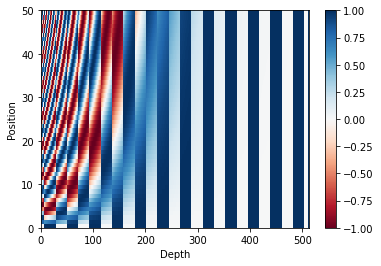

In [284]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.xlim((0, 512))
plt.xlabel('Depth')
plt.ylabel('Position')
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.colorbar()
plt.show()

### attention function

In [231]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


In [232]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
                to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights


##### *how it works*

In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)


In [ ]:
# np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[8.433274e-26 1.000000e+00 8.433274e-26 8.433274e-26]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[1.000000e+01 9.276601e-25]], shape=(1, 2), dtype=float32)


### Attention

In [395]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights


### VAE

In [449]:
latent_dim = 2048

In [474]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()

        self.inp = tf.keras.layers.InputLayer(input_shape=(max_length))
        self.emb = tf.keras.layers.Embedding(
            word_vocab.vocab_size, emb_size,
            embeddings_initializer=tf.keras.initializers.Constant(embeddings),
            trainable=True
        )

        self.mha_1 = MultiHeadAttention(d_model=256, num_heads=32)
        self.mha_2 = MultiHeadAttention(d_model=128, num_heads=32)
        self.mha_3 = MultiHeadAttention(d_model=64, num_heads=32)

        self.flatten = tf.keras.layers.Flatten()
        self.latent = tf.keras.layers.Dense(latent_dim + latent_dim)

    def call(self, x, training=None):
        seq = self.inp(x)
        emb = self.emb(seq)
        mask = create_padding_mask(seq)

        att_1, _ = self.mha_1(emb, emb, emb, mask)
        att_2, _ = self.mha_2(att_1, att_1, att_1, mask)
        att_3, _ = self.mha_3(att_2, att_2, att_2, mask)  # (128, 32, 64)

        flatten = self.flatten(att_3)  # (128, 2048)
        latent = self.latent(flatten)
        return latent


In [475]:
2048 == 32 * 64

True

In [476]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()

        self.inp = tf.keras.layers.InputLayer(input_shape=(latent_dim,))
        self.reshape = tf.keras.layers.Reshape(target_shape=(32, 64))

        self.mha = MultiHeadAttention(d_model=64, num_heads=1)

        # No activation
        self.logits = tf.keras.layers.Conv1D(
            filters=word_vocab.vocab_size, kernel_size=1, strides=1, padding='same'
        )

    def call(self, x, training=None):
        seq = self.inp(x)
        seq = self.reshape(seq)

        att, _ = self.mha(seq, seq, seq, mask=None)  # (128, 32, 64) 
        logits = self.logits(att)  # (128, 32, 2002)
        return logits


In [477]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = Encoder()
        self.decoder = Decoder()

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, log_variance = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, log_variance

    def reparameterize(self, mean, log_variance):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_variance * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


In [478]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, log_variance, raxis=1):
    log_2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2. * tf.exp(-log_variance) + log_variance + log_2pi), axis=raxis)


def compute_loss(model, x):
    mean, log_variance = model.encode(x)
    z = model.reparameterize(mean, log_variance)

    x_logits = model.decode(z)
    x_labels = tf.one_hot(x, depth=word_vocab.vocab_size, dtype='float32')
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=x_labels)

    log_px_z = -tf.reduce_sum(cross_entropy, axis=[1, 2])
    log_pz = log_normal_pdf(z, 0., 0.)
    log_qz_x = log_normal_pdf(z, mean, log_variance)
    return -tf.reduce_mean(log_px_z + log_pz - log_qz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [479]:
def decode_sentences(sentences):
    sentences = [word_vocab.decode_words(sentence) for sentence in sentences]
    sentences = [' '.join(sentence) for sentence in sentences]
    return sentences


def generate_sentences(model, sentences):
    mean, log_variance = model.encode(sentences)
    z = model.reparameterize(mean, log_variance)

    predictions = model.sample(z)
    predictions = np.argmax(predictions, axis=-1)
    return decode_sentences(predictions)


# Training

In [480]:
tf.keras.backend.clear_session()

In [481]:
epochs = 200
num_examples_to_generate = 8

model = CVAE(latent_dim)

In [482]:
assert batch_size >= num_examples_to_generate

for test_batch in test_sentences.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :]


In [483]:
decode_sentences(test_sample.numpy())

['a group of three people are digging a large trench in a yard while another person walks close by . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 'a little boy with an orange backpack walks under a tree through the woods . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 'young asian male child either smoking something or its an instrument . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 'a woman in a scarf , laughing , being [UNK] by a dog . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 'a father and son are in a field of yellow flowers . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 'female in a military uniform with her hair tied back . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_sentences:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_sentences:
        loss(compute_loss(model, test_x))
    
    elbo = -loss.result()
    display.clear_output(wait=False)

    print(f'Epoch: {epoch}, Test set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time}')
    for sentence in generate_sentences(model, test_sample):
        print(sentence)


Epoch: 121, Test set ELBO: -105.37326049804688, time elapse for current epoch: 10.848875999450684
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

# Test

In [ ]:
# 100 epochs - no embs pretrained
# workers wearing orange vests stand near rail tracks . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# rider in ceremonial garb rides white arabian horse , also wearing ceremonial blankets and tassels . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# four young female gymnasts dressed in black and blue leotards are preparing for their next routine . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# three men are standing on stage performing . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

# Epoch: 23, Test set ELBO: -82.9482650756836, time elapse for current epoch: 10.455499410629272
# a man is a a a a a a a a a a . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is a a a a a a a . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is a a a a a a a a a a . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is a a a a a a a a a a a a a a a a [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

# Epoch: 67, Test set ELBO: -60.924598693847656, time elapse for current epoch: 20.23077392578125
# the is are are a a a a . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# rider young ceremonial garb a a arabian horse , also is ceremonial blankets the tassels . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# an young in in a a a and , a a a a a a . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# two people are in in the . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

# Epoch: 100, Test set ELBO: -48.98137283325195, time elapse for current epoch: 20.519086360931396
# there are men are cruising in the field . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# rider in ceremonial garb rides white arabian horse , also wearing ceremonial blankets and tassels . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# two beautiful in little coat and - hair - and jeans hair making forming cheeks . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# the people are playing a a . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [ ]:
# 100 epochs - embs glove.840B.300d trainable=False
# batter hits a baseball [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a younger couple is walking across a crosswalk outside with a very busy bus stop behind them . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# women in blue dress singing on stage . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a windsurfer catching air with water streaming off of the board . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# workers are scattered among the scaffolding on an older building . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# two small boys in blue soccer uniforms use a wooden set of steps to wash their hands in an adult - sized bathroom . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a mother holds her newborn baby . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# six males , four with shirts and two without , have taken a break from their construction work on a building . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

# Epoch: 27, Test set ELBO: -73.20726013183594, time elapse for current epoch: 38.25634050369263
# a man is a a . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man in a a a a a a a a a a a [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is in a the . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is a a a a a a a . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is a a a a a . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man in a a shirt and a a a a a a a a a a a a a [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is in a a . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man in a a shirt and a shirt a a a a a a a a a a a . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

# Epoch: 70, Test set ELBO: -62.30364227294922, time elapse for current epoch: 37.70615196228027
# the are are [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a group of people a a a a a a a of a in in the them . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is is in a street . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is is a a a a a the water . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is in a a in a a . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a group of in a a a , , and and , , christmas a a a , residential pouring in the background . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a are is a a . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# two men are one in a a a a , with a a , the with a in in the . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

# Epoch: 100, Test set ELBO: -58.14429473876953, time elapse for current epoch: 37.622807025909424
# people are [PAD] . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a group of people are a a a of a front of the building with the them . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# two men are walking in the street . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is a a in a in a a pool . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# two people are on a a on a a . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a dramatic of are a a a row , " angry with steps , chokes the a her material sticks in the tongue . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is a a outside . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# two men , one couch a one , and , and other a and a the construction cones gun of it . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [207]:
def get_exact_match_score(sample, prediction):
    sample = [word for word in sample if word != '[PAD]']

    head = [1 for s_word, p_word in zip(sample, prediction) if s_word == p_word]
    tail = [1 for word in prediction[len(sample):] if word != '[PAD]']

    score = (sum(head) - sum(tail)) / len(sample)
    return score


In [208]:
scores = []

for sample in test_sentences:
    sentences = decode_sentences(sample.numpy())
    predictions = generate_sentences(model, sample)

    scores += [
        get_exact_match_score(sentence, prediction)
        for sentence, prediction in zip(sentences, predictions)
    ]
      

np.min(scores), np.max(scores), np.mean(scores)

(-0.3142857142857143, 1.0, 0.175789705664124)

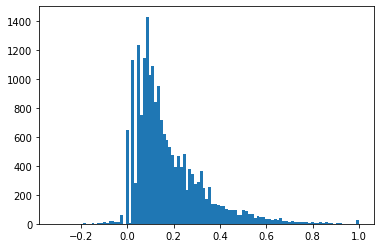

In [209]:
plt.hist(scores, bins='auto')
plt.show()

In [ ]:
scores = []

for sample in test_sentences:
    sentences = decode_sentences(sample.numpy())
    predictions = generate_sentences(model, sample)

    scores += [
        get_exact_match_score(sentence, prediction)
        for sentence, prediction in zip(sentences, predictions)
    ]
      

np.min(scores), np.max(scores), np.mean(scores)

(-0.18055555555555555, 1.0, 0.1321324926561673)

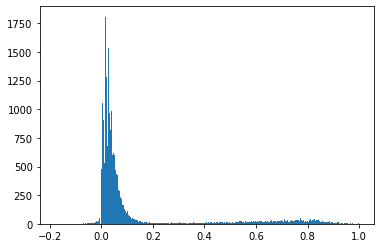

In [ ]:
plt.hist(scores, bins='auto')
plt.show()